# Elastic Full Proc2D Means

Zwei Probleme:
1. Mean ist an den Enden etwas zu "lang".
2. Rotation und Scaling der Procrustes SRV Kurven lässt sich nicht einfach auf die Data Curves übertragen.

#### Veranschaulichung:

In [38]:
library(elasdics)

ProcrustesLoad some datasets with random rotation and scaling.

In [39]:
source("/home/mnl/Statistik/masterthesis/code/datasets.R")
set.seed(18)

data_curves <- curves.spiral(n_curves=4, rotate=TRUE, scale=TRUE, center=TRUE)
data_curves2 <- curves.digit3(rotate=TRUE, scale=TRUE, center=TRUE)

Take a look at the data curves.

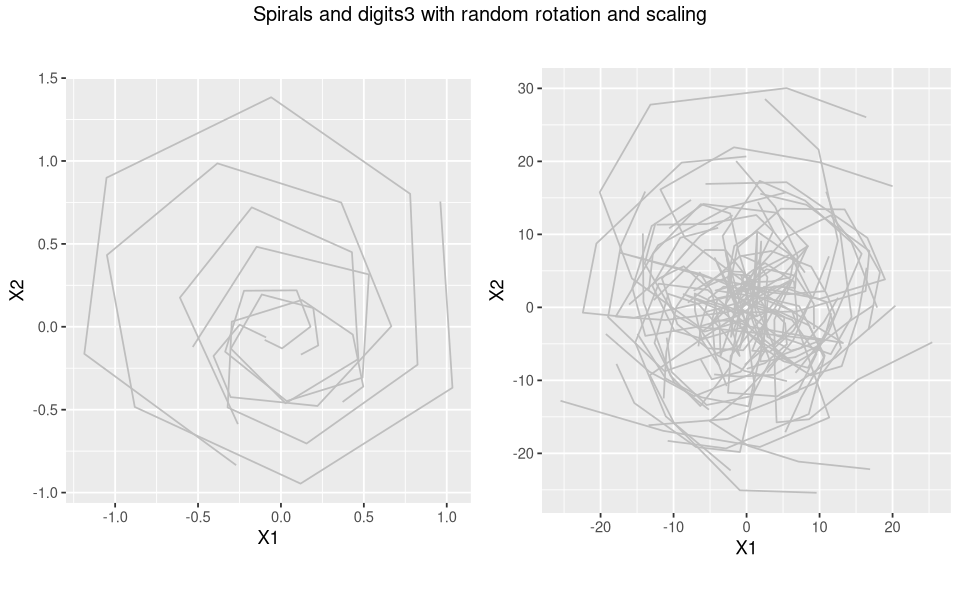

In [74]:
library(ggplot2)
library(gridExtra)
library(dplyr)

p1 <- ggplot(bind_rows(data_curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed()

p2 <- ggplot(bind_rows(data_curves2, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed()

# Display plots in smaller size
options(repr.plot.width=8, repr.plot.height=5)

grid.arrange(p1, p2, nrow=1, top="Spirals and digits3 with random rotation and scaling")

#### Calculate Smooth Elastic Mean
Switch out ```compute_elastic_mean``` function in Lisa's ```elasdics``` package namespace with my own version that implements procrustes 2d means.

[1] "Number of basis functions:  120"
[1] "Knots (from):"
 [1] 0.00000000 0.00000000 0.00000000 0.00000000 0.08333333 0.16666667
 [7] 0.25000000 0.33333333 0.41666667 0.50000000 0.58333333 0.66666667
[13] 0.75000000 0.83333333 0.91666667 1.00000000 1.00000000 1.00000000
[19] 1.00000000
[1] "-------------------------------"
[1] "Printing summary and plotting fit"

Family: gaussian 
Link function: identity 

Formula:
Re(qq) ~ s(t, s, bs = "sps", k = cov.k, m = c(cov.m, 0), fx = FALSE, 
    xt = list(skew = FALSE))

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.61047    0.09852  -6.197 4.97e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
         edf Ref.df     F p-value    
s(t,s) 65.81    112 18.97  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.906   Deviance explained = 93.4%
-REML = 503.67  Scale est. = 2.1546    n = 222


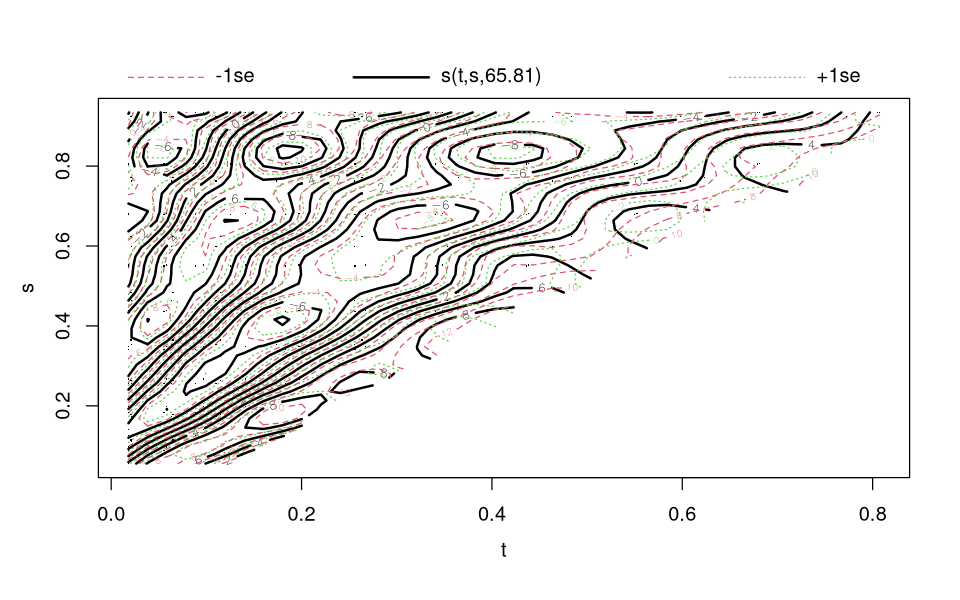

In [375]:
source("/home/mnl/Statistik/masterthesis/code/modify_compute_elastic_mean.R")  # Switcheroo~

# Turn of warnings
defaultW <- getOption("warn")
options(warn = -1)

# Compute Means
knots <- seq(0,1, length = 13)
smooth_elastic_mean <- compute_elastic_mean(data_curves, knots = knots, proc2d = TRUE)
knots2 <- seq(0,1, length = 12)
#smooth_elastic_mean2 <- compute_elastic_mean(data_curves2, knots = knots2, proc2d = TRUE)

# Turn on warnings
options(warn = defaultW)

#### Zwei Varianten die Procrustes fits der data curves zu berechnen
1. Naiver Ansatz: Procrustes fits of curve $\beta_i(t)$ calculated directly as $\beta_i^p(t) = 
\frac{<\beta_i, \hat{\mu}>}{<\beta_i, \beta_i>} \beta_i(t)$, with $<\cdot,\cdot>$ complex scalar product.

Anmerkung: Das klappt schon recht gut. Der berechnete procrustes mean $\hat{\mu}$ sieht aber an den "Enden" etwas zu lang aus. Da bin ich gerade noch am überlegen, woran das liegt.

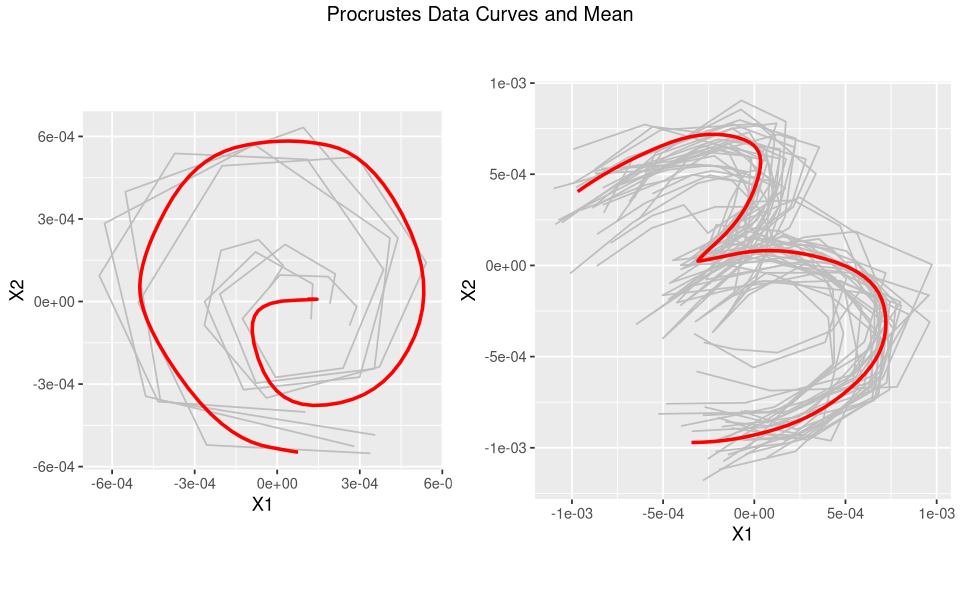

In [376]:
align_curve_proc2d <- function(data_curve, mean, grid.len = 101){
    #data_curve <- center_curve(data_curve)
    # Evaluate mean function on grid.
    arg.grid = seq(0,1,len = grid.len)
    mean_eval = get_evals(mean, t=arg.grid)
    mean_eval = complex(real = mean_eval[,1], imaginary = mean_eval[,2])
    # Evaluate curve on arg.grid.
    b_coefs <- as.matrix(data_curve[,c(-1,-2)])
    # ToDo: How to smooth here? Use type="smooth" for now.
    b_eval <- elasdics:::make_design(arg.grid, knots = data_curve$t_optim) %*% b_coefs
    b_eval <- complex(real = b_eval[,1], imaginary = b_eval[,2])
    # Calculate proc2d fit on evaluated curve.
    # Note: Functional scalar products here, that's why I evaluate
    #       mean and data_curve on dense arg.grid to approximate the 
    #       integral with a sum. Is that correct?
    bm <- Conj(b_eval) %*% mean_eval
    bb <- Conj(b_eval) %*% b_eval
    # Apply rotation+scaling to original curve, return.
    b_compl <- complex(real = b_coefs[,1], imaginary = b_coefs[,2])
    pfit <- as.vector(bm) * b_compl / as.vector(bb)
    data.frame(t = data_curve$t, t_optims = data_curve$t, X1 = Re(pfit), X2 = Im(pfit))
}

pfits <- lapply(smooth_elastic_mean$data_curves, function(x) {
        align_curve_proc2d(x, smooth_elastic_mean)
})
pfits2 <- lapply(smooth_elastic_mean2$data_curves, function(x) {
    align_curve_proc2d(x, smooth_elastic_mean2)
})

p1 <- ggplot(bind_rows(pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

p2 <- ggplot(bind_rows(pfits2, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean2), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

grid.arrange(p1, p2, nrow=1, widths=8:9, top="Procrustes Data Curves and Mean")

2. Procrustes fit of curve $\beta_i^p(t)$ calculated as $\beta_i^p(t) = \text{b}^2 e^{i\text{G}} \, \beta_i(t)$. With $b$ and $G$ calculated from the procrustes fit of the SRV curves $q_i^p(t) = \text{b} e^{i\text{G}} q_i(t)$.

Anmerkung: Das passt leider überhaupt nicht. Ich verstehe aber nicht genau warum. Meine (zu simple?) Überlegung war: 

$$\beta_i^p(t) + T = \int_0^t q_i^p(s) \, ||q_i^p(s)|| \, \text{d}s \, = 
    \int_0^t  \text{b} e^{i\text{G}} q_i(s) \, || \text{b} e^{i\text{G}} q_i(s)|| \, \text{d}s \, =
    \text{b}^2 e^{i\text{G}} \, \int_0^t q_i(s) \, ||q_i(s)|| \, \text{d}s \, =
    \text{b}^2 e^{i\text{G}} \, \beta_i(t)$$

da $\text{b} > 0$ und $||e^{i\text{G}}|| = 1$, mit Translation $T$ (und $T=0$ assuming centered curves).

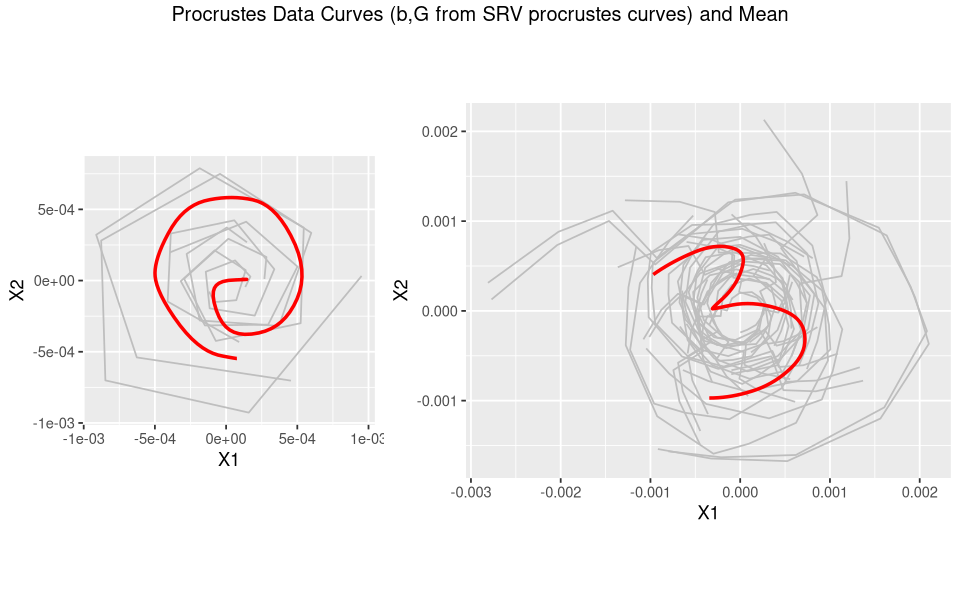

In [377]:
p1 <- ggplot(bind_rows(smooth_elastic_mean$procrustes_fits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

p2 <- ggplot(bind_rows(smooth_elastic_mean2$procrustes_fits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean2), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

grid.arrange(p1, p2, nrow=1, widths = 2:3, top="Procrustes Data Curves (b,G from SRV procrustes curves) and Mean")

### Test knots and spline basis representation

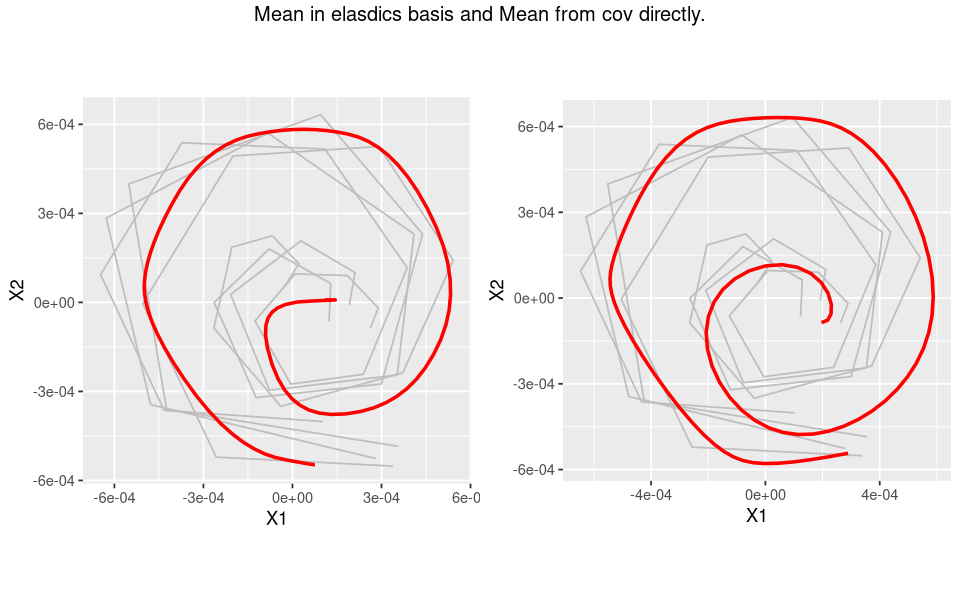

In [378]:
smooth_elastic_mean_smooth = smooth_elastic_mean
smooth_elastic_mean_smooth$coefs = smooth_elastic_mean$coefs_smooth
smooth_elastic_mean_smooth$knots = smooth_elastic_mean$knots_smooth

p1 <- ggplot(bind_rows(pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

p2 <- ggplot(bind_rows(pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean_smooth), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

grid.arrange(p1, p2, nrow=1, top="Mean in elasdics basis and Mean from cov directly.")